In [1]:
!pip install torch_snippets
import torch
from torch_snippets import *
from torchvision import transforms as T
from torch.nn import functional as F
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
from torchvision import transforms as T
preprocess = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
    T.Lambda(lambda x: x.mul_(255))
])

postprocess=T.Compose([
    T.Lambda(lambda x: x.mul_(1./255)),
    T.Normalize(
        mean=[-0.485/0.299, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.255])
])

In [3]:
#@ Gram Matrix module:
class GramMatrix(torch.nn.Module):
  def forward(self, input):
    b, c, h, w=input.size()
    feature=input.view(b, c, h*w)
    G= feature @ feature.transpose(1, 2)
    G.div_(h*w)
    return G

In [19]:
class GramMSELoss(torch.nn.Module):
  def forward(self, input, target):
    output=F.mse_loss(GramMatrix()(input), target)
    return(output)

In [20]:
#@ VGG-19 modified:
class vgg19_modified(torch.nn.Module):
  def __init__(self):
    super().__init__()

    #extracting the feature:
    features=list(models.vgg19(pretrained=True).features)
    self.features=torch.nn.ModuleList(features).eval()

  def forward(self, x, layers=[]):
    order=np.argsort(layers)
    _results, results=[], []
    for ix, model in enumerate(self.features):
      x=model(x)
      if ix in layers: _results.append(x)
    for o in order: results.append(_results[o])
    return results if layers is not [] else x

In [21]:
from torchvision import models
vgg=vgg19_modified().to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [37]:
#@ Importing content and style image:
!wget https://imgs.search.brave.com/eUi39PEYjzDkXxol6pxOjNEeBIciERVGXthMGIFQJSA/rs:fit:860:0:0:0/g:ce/aHR0cHM6Ly9jZG4u/Y25uLmNvbS9jbm4v/aW50ZXJhY3RpdmUv/MjAyMi8xMi93b3Js/ZC9iZXN0LXNwYWNl/LXBob3Rvcy0yMDIy/L21lZGlhL2ltYWdl/cy93ZWJiLTEzLTA3/LWp1bHktU3Rhci1G/b3JtaW5nLVJlZ2lv/bi1NQUlOLUlNQUdF/LS0tQ2FyaW5hLmpw/Zw
!wget https://imgs.search.brave.com/ECF43vmppH_PCAtkNGy2a4Rw7muIOVXHNwGqIsnbjlE/rs:fit:500:0:0:0/g:ce/aHR0cHM6Ly90My5m/dGNkbi5uZXQvanBn/LzAyLzI0LzI0LzA2/LzM2MF9GXzIyNDI0/MDYzOF85Y2cxN2hH/dEp3NTRKNGtMakxO/c1U2RWZZaUJvSlVj/SS5qcGc

--2025-03-09 09:21:29--  https://imgs.search.brave.com/eUi39PEYjzDkXxol6pxOjNEeBIciERVGXthMGIFQJSA/rs:fit:860:0:0:0/g:ce/aHR0cHM6Ly9jZG4u/Y25uLmNvbS9jbm4v/aW50ZXJhY3RpdmUv/MjAyMi8xMi93b3Js/ZC9iZXN0LXNwYWNl/LXBob3Rvcy0yMDIy/L21lZGlhL2ltYWdl/cy93ZWJiLTEzLTA3/LWp1bHktU3Rhci1G/b3JtaW5nLVJlZ2lv/bi1NQUlOLUlNQUdF/LS0tQ2FyaW5hLmpw/Zw
Resolving imgs.search.brave.com (imgs.search.brave.com)... 18.164.174.92, 18.164.174.127, 18.164.174.43, ...
Connecting to imgs.search.brave.com (imgs.search.brave.com)|18.164.174.92|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 96462 (94K) [image/jpeg]
Saving to: ‘Zw’

Zw                  100%[===================>]  94.20K  --.-KB/s    in 0.02s   

2025-03-09 09:21:29 (5.36 MB/s) - ‘Zw’ saved [96462/96462]

--2025-03-09 09:21:29--  https://imgs.search.brave.com/ECF43vmppH_PCAtkNGy2a4Rw7muIOVXHNwGqIsnbjlE/rs:fit:500:0:0:0/g:ce/aHR0cHM6Ly90My5m/dGNkbi5uZXQvanBn/LzAyLzI0LzI0LzA2/LzM2MF9GXzIyNDI0/MDYzOF85Y2cxN2hH/dEp3NTRKNGtMakxO/c1U2RWZZa

In [38]:
imgs=[Image.open(path).resize((512, 512)).convert('RGB') for path in ['Zw', 'SS5qcGc.1']]
style_image, content_image = [preprocess(img).to(device).unsqueeze(0) for img in imgs]


In [39]:
opt_img=content_image.data.clone()
opt_img.requires_grad=True

In [40]:
style_layers=[0, 5, 10, 19, 28]
content_layers=[21]
loss_layers=style_layers + content_layers

In [41]:
loss_fns=[GramMSELoss()] * len(style_layers) + [torch.nn.MSELoss()] * len(content_layers)
loss_fns=[loss_fn.to(device) for loss_fn in loss_fns]

In [42]:
#@ defining weightage associated with content and style loss:
style_weights=[1000/n**2 for n in [64, 128, 256, 512, 512]]
content_weights=[1]
weights=style_weights + content_weights

In [43]:
style_targets=[GramMatrix()(A).detach() for A in vgg(style_image, style_layers)]
content_targets=[A.detach() for A in vgg(content_image, content_layers)]
targets=style_targets + content_targets

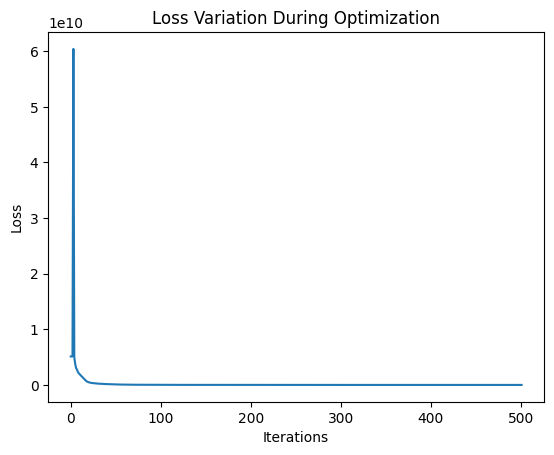

In [44]:
import matplotlib.pyplot as plt

max_iters = 500
optimizer = torch.optim.LBFGS([opt_img])

loss_values = []  # Store loss values

iters = 0
while iters < max_iters:
    def closure():
        global iters
        iters += 1
        optimizer.zero_grad()
        output = vgg(opt_img, loss_layers)
        layer_losses = [weights[a] * loss_fns[a](A, targets[a]) for a, A in
         enumerate(output)]
        loss = sum(layer_losses)
        loss.backward()
        loss_values.append(loss.item())  # Store loss
        return loss

    optimizer.step(closure)

# Plot the loss variation
plt.plot(loss_values)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Loss Variation During Optimization")
plt.show()


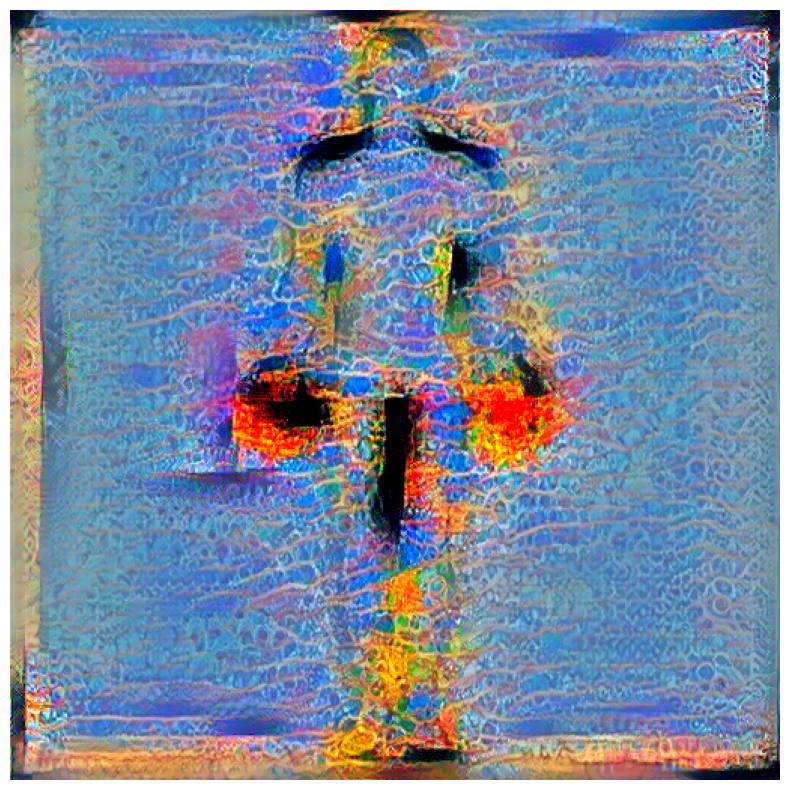

In [36]:
with torch.no_grad():
    out_img = postprocess(opt_img[0]).permute(1,2,0)
    show(out_img)
